<a href="https://colab.research.google.com/github/shabahmd/Machine-Learning-Notebooks/blob/main/Machine_Prediction_of_Piousness_Mashrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedShuffleSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, accuracy_score,matthews_corrcoef
import scipy
import warnings
warnings.filterwarnings('ignore')


In [3]:
!mkdir ~/.kaggle



!mv kaggle.json ~/.kaggle/



!chmod 600 ~/.kaggle/kaggle.json



!kaggle competitions download -c playground-series-s4e8


mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
 91% 75.0M/82.3M [00:00<00:00, 86.3MB/s]
100% 82.3M/82.3M [00:00<00:00, 87.1MB/s]


In [4]:
!unzip playground-series-s4e8

Archive:  playground-series-s4e8.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission_data = pd.read_csv(r"sample_submission.csv")


In [6]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

class
p    1705396
e    1411549
Name: count, dtype: int64


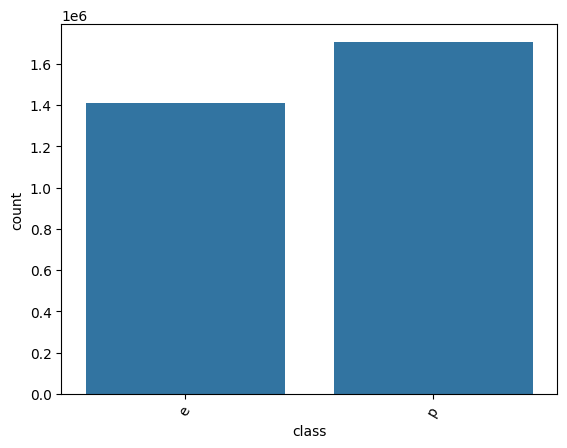

In [8]:
print(train_data['class'].value_counts())
sns.countplot(x ='class', data = train_data)
plt.xticks(rotation= 60)
plt.show()

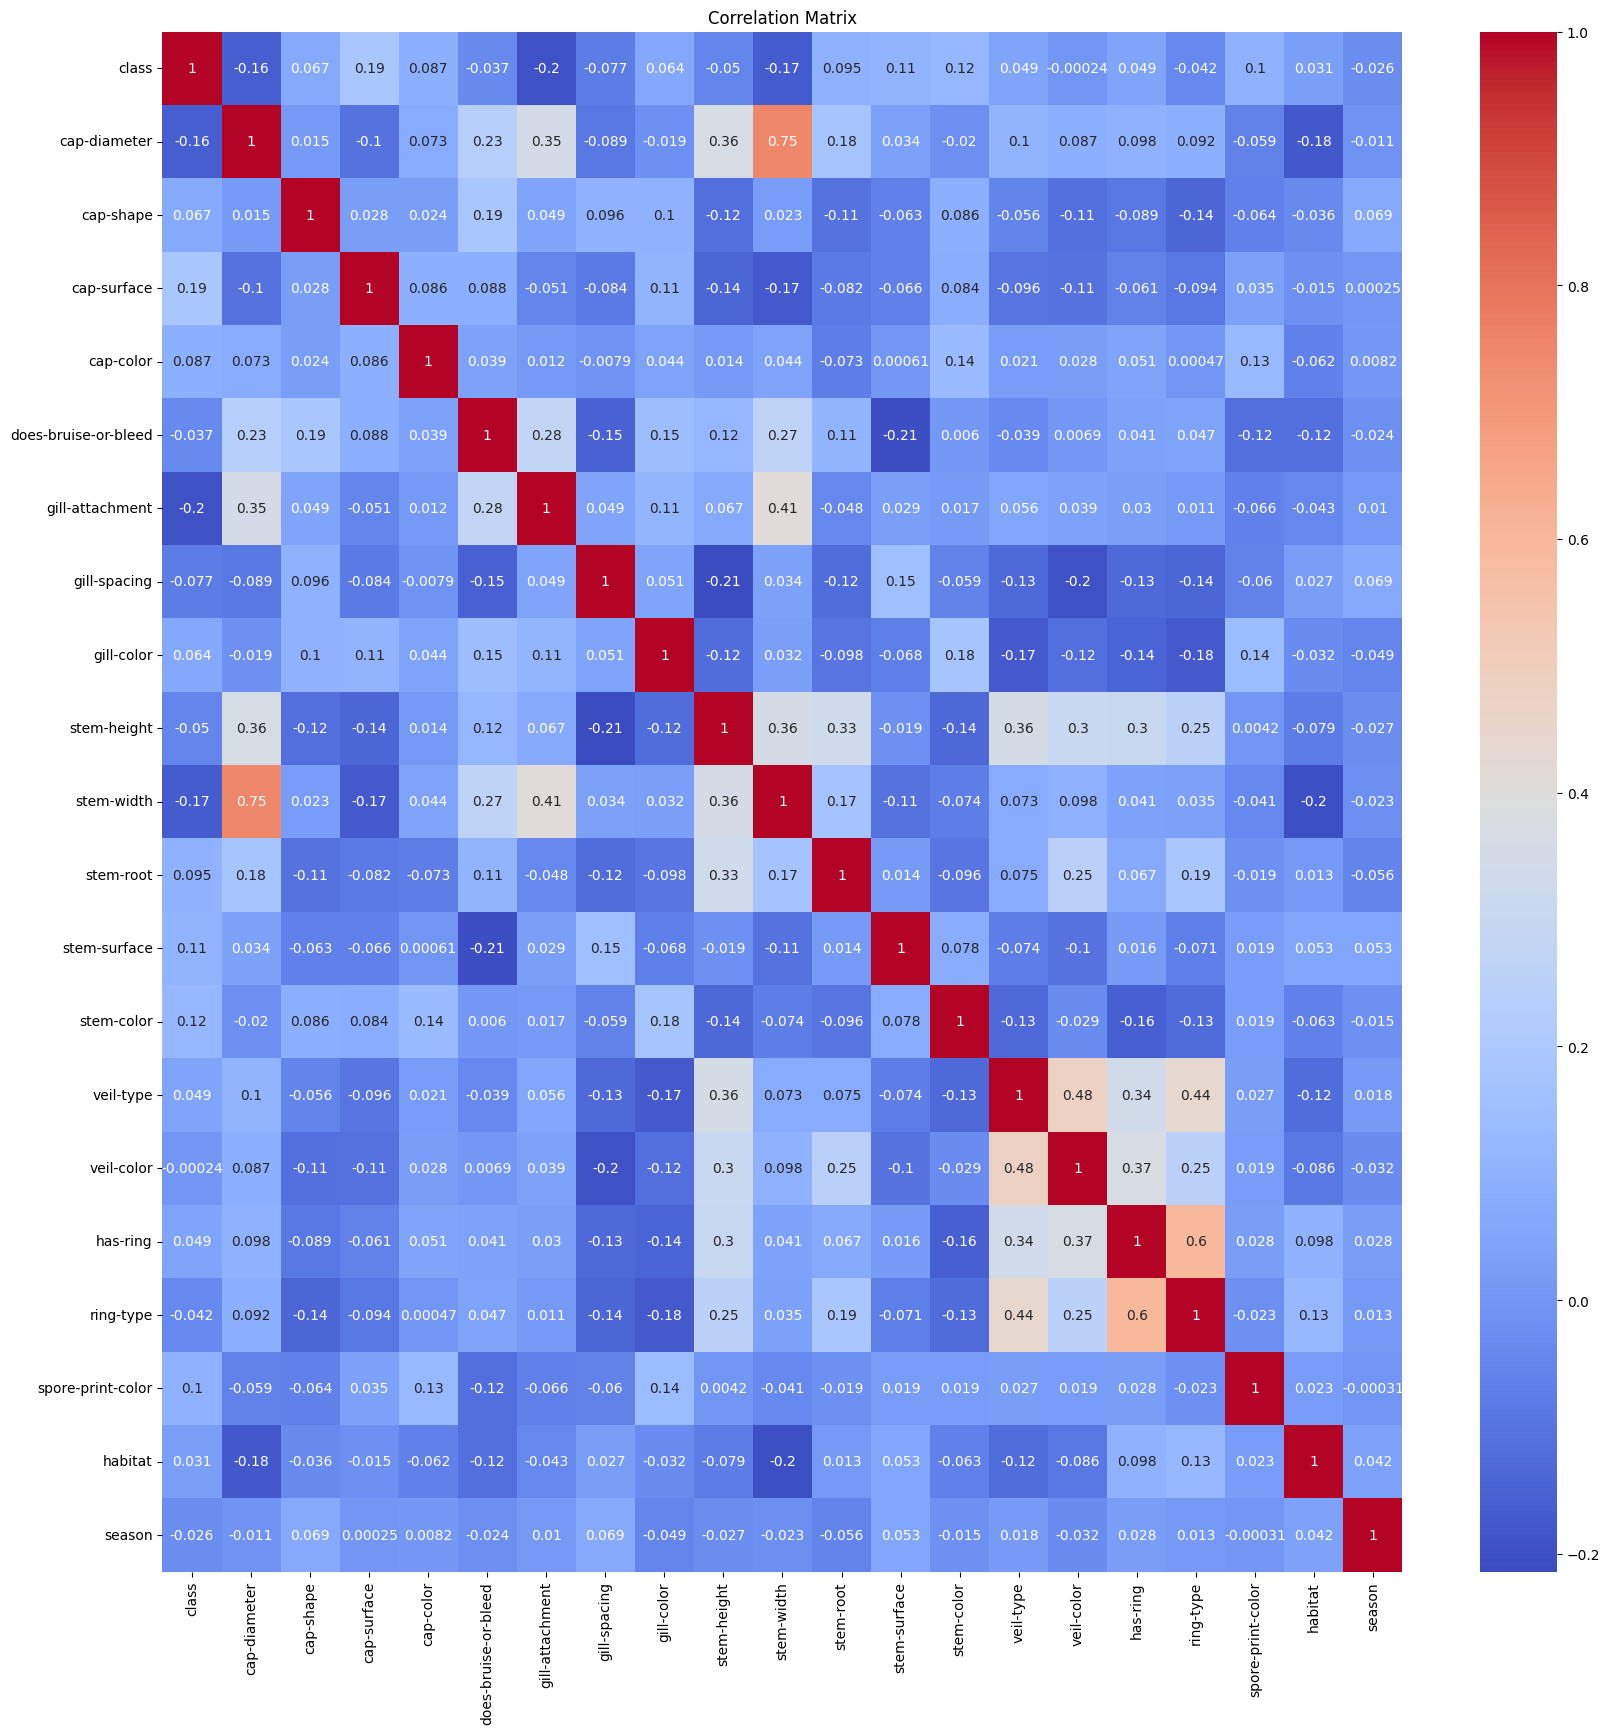

In [9]:
df_dropped = train_data.dropna()
df_dropped = train_data.drop('id', axis =1)
df_encoded = df_dropped.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else  x)

correlation_matrix = df_encoded.corr()

correlation_matrix
plt.figure(figsize =(20, 20))
sns.heatmap(correlation_matrix, annot= True, cmap= 'coolwarm')

plt.title('Correlation Matrix')
plt.show()

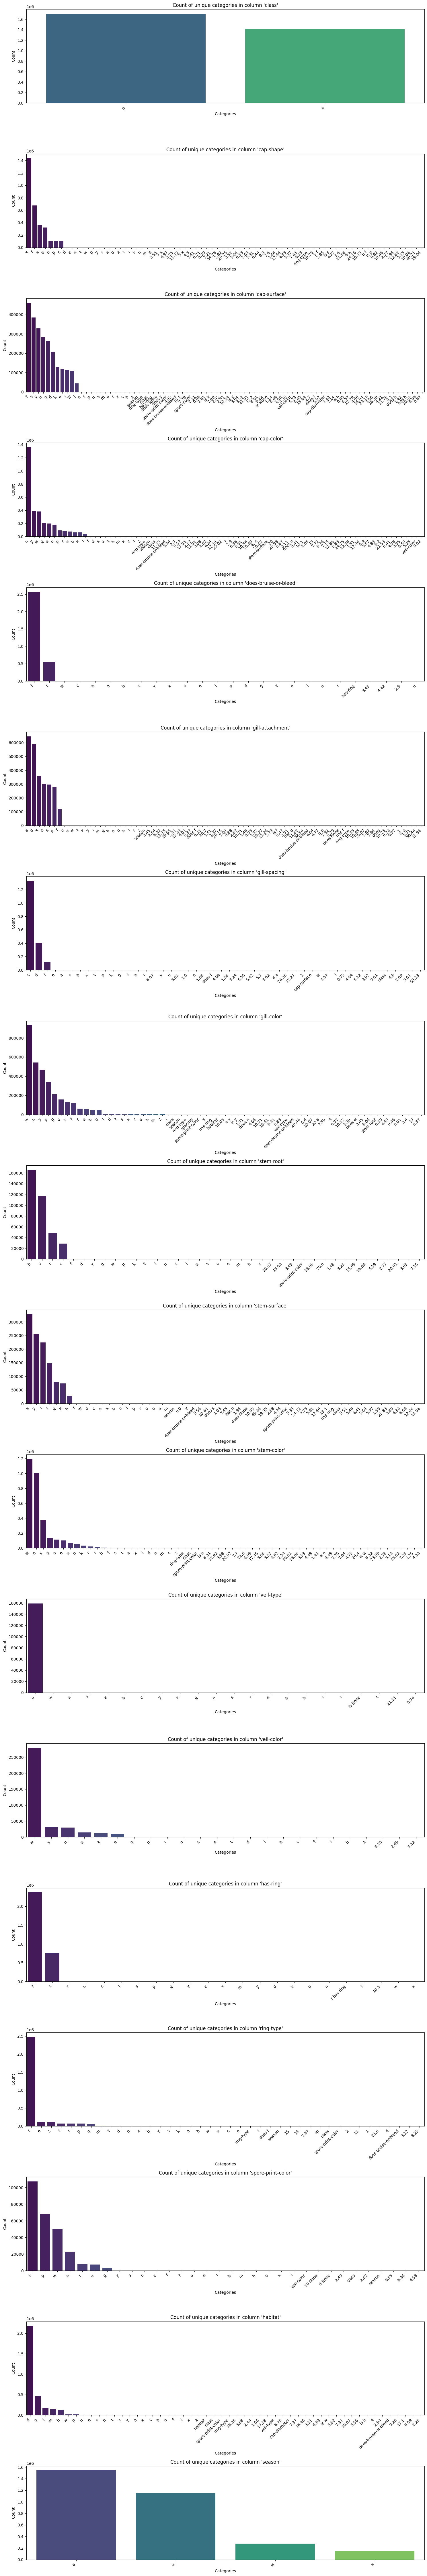

In [10]:
cate_col = train_data.select_dtypes(include=['object']).columns

# Find unique categories and their counts for each categorical column
unique_categories = {col: train_data[col].value_counts() for col in cate_col}

# Set the size of the overall figure
plt.figure(figsize=(15, len(cate_col) * 5))

# Plot the count of each unique category
for i, (col, counts) in enumerate(unique_categories.items(), 1):
    plt.subplot(len(cate_col), 1, i)
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.title(f"Count of unique categories in column '{col}'")
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()


In [11]:
def null_percent(df):
  per = ((df.isnull().sum()/len(df))*100).round(4)
  return per

print('Nan values in Train data')
print(null_percent(train_data))
print(null_percent(test_data))


Nan values in Train data
id                       0.0000
class                    0.0000
cap-diameter             0.0001
cap-shape                0.0013
cap-surface             21.5282
cap-color                0.0004
does-bruise-or-bleed     0.0003
gill-attachment         16.8093
gill-spacing            40.3740
gill-color               0.0018
stem-height              0.0000
stem-width               0.0000
stem-root               88.4527
stem-surface            63.5514
stem-color               0.0012
veil-type               94.8843
veil-color              87.9370
has-ring                 0.0008
ring-type                4.1348
spore-print-color       91.4255
habitat                  0.0014
season                   0.0000
dtype: float64
id                       0.0000
cap-diameter             0.0003
cap-shape                0.0015
cap-surface             21.5068
cap-color                0.0006
does-bruise-or-bleed     0.0005
gill-attachment         16.8348
gill-spacing            40.4047


In [12]:
alpha = 0.05
values = {}

for col in train_data.columns:
    if col == "class":
        continue

    A, B = train_data[col], train_data["class"]

    dfObserved = pd.crosstab(A, B)
    chi2, p, dof, expected = scipy.stats.chi2_contingency(dfObserved.values)
    values[col] = p
    if p < alpha:
        # Reject null hypothesis
        print("{} is important. (p = {})".format(col, p))
    else:
        # Accept null hypothesis
        print("{} is NOT important. (p = {})".format(col, p))


id is NOT important. (p = 0.4997336950403224)
cap-diameter is important. (p = 0.0)
cap-shape is important. (p = 0.0)
cap-surface is important. (p = 0.0)
cap-color is important. (p = 0.0)
does-bruise-or-bleed is important. (p = 0.0)
gill-attachment is important. (p = 0.0)
gill-spacing is important. (p = 0.0)
gill-color is important. (p = 0.0)
stem-height is important. (p = 0.0)
stem-width is important. (p = 0.0)
stem-root is important. (p = 0.0)
stem-surface is important. (p = 0.0)
stem-color is important. (p = 0.0)
veil-type is NOT important. (p = 0.37683440676671315)
veil-color is important. (p = 0.0)
has-ring is important. (p = 0.0)
ring-type is important. (p = 0.0)
spore-print-color is important. (p = 0.0)
habitat is important. (p = 0.0)
season is important. (p = 0.0)


In [13]:
train_data =  train_data.drop(['id', 'veil-color', 'veil-type'], axis =1)
test_data = test_data.drop(['id',"veil-color",'veil-type'], axis=1)


In [14]:
numeric_feats = [ 'cap-diameter', 'stem-height', 'stem-width']
for feat in numeric_feats:
  median_value = train_data[feat].mode()[0]
  train_data[feat].fillna(median_value, inplace = True)

In [15]:
def detect_outliers_iqr(data, column):
  Q1 = data[column].quantile(0.01)
  Q3 = data[column].quantile(0.99)
  IQR = Q3 - Q1
  lower_bound =  Q1 - 1.5 * IQR
  upper_bound =  Q3 + 1.5 * IQR
  return data[(data[column]< lower_bound) | (data[column]>upper_bound)]
for column in numeric_feats:
  outliers = detect_outliers_iqr(train_data, column)
  print(f'Number of outliers in {column}: {outliers.shape[0]}')

Number of outliers in cap-diameter: 11358
Number of outliers in stem-height: 35
Number of outliers in stem-width: 26


In [16]:
def cap_outliers(data, column):
  Q1 = data[column].quantile(0.01)
  Q3 = data[column].quantile(0.99)
  IQR = Q3- Q1
  lower_bound = Q1 -1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  data[column]  = np.where(data[column]< lower_bound, lower_bound, data[column])
  data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

for column in numeric_feats:
  cap_outliers(train_data, column)
  cap_outliers(test_data, column)



In [17]:
import pandas as pd

def cleaning(df):
    threshold = 100

    cat_feats = ["cap-shape", "cap-surface", "cap-color", "does-bruise-or-bleed", "gill-attachment",
                "gill-spacing", "gill-color", "stem-root", "stem-surface", "stem-color",
                 "has-ring", "ring-type", "spore-print-color", "habitat", "season"]

    for feat in cat_feats:
        if df[feat].dtype.name == 'category':
            # Add 'missing' and 'noise' to categories if not present
            if 'missing' not in df[feat].cat.categories:
                df[feat] = df[feat].cat.add_categories('missing')
            if 'noise' not in df[feat].cat.categories:
                df[feat] = df[feat].cat.add_categories('noise')
        else:
            # Convert to category and add new categories
            df[feat] = df[feat].astype('category')
            df[feat] = df[feat].cat.add_categories(['missing', 'noise'])

        # Fill missing values with 'missing'
        df[feat] = df[feat].fillna('missing')

        # Replace infrequent categories with 'noise'
        counts = df[feat].value_counts(dropna=False)
        infrequent_categories = counts[counts < threshold].index
        df[feat] = df[feat].apply(lambda x: 'noise' if x in infrequent_categories else x)

    return df

# Example usage
train_data = cleaning(train_data)
test_data = cleaning(test_data)



In [18]:
train_data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,missing,missing,w,f,f,missing,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,missing,y,o,t,z,missing,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,missing,s,n,f,f,missing,l,w
3,e,3.88,f,y,g,f,s,missing,g,4.16,6.53,missing,missing,w,f,f,missing,d,u
4,e,5.85,x,l,w,f,d,missing,w,3.37,8.36,missing,missing,w,f,f,missing,g,a


In [19]:
print(null_percent(train_data))


class                   0.0
cap-diameter            0.0
cap-shape               0.0
cap-surface             0.0
cap-color               0.0
does-bruise-or-bleed    0.0
gill-attachment         0.0
gill-spacing            0.0
gill-color              0.0
stem-height             0.0
stem-width              0.0
stem-root               0.0
stem-surface            0.0
stem-color              0.0
has-ring                0.0
ring-type               0.0
spore-print-color       0.0
habitat                 0.0
season                  0.0
dtype: float64


In [20]:
cat_feats = ["cap-shape", "cap-surface", "cap-color", "does-bruise-or-bleed", "gill-attachment",
             "gill-spacing", "gill-color", "stem-root", "stem-surface", "stem-color",
              "has-ring", "ring-type", "spore-print-color", "habitat", "season"]

for feat in cat_feats:
  train_data[feat] =  train_data[feat].astype('category')
for feat in cat_feats:
    test_data[feat] = test_data[feat].astype('category')


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 19 columns):
 #   Column                Dtype   
---  ------                -----   
 0   class                 object  
 1   cap-diameter          float64 
 2   cap-shape             category
 3   cap-surface           category
 4   cap-color             category
 5   does-bruise-or-bleed  category
 6   gill-attachment       category
 7   gill-spacing          category
 8   gill-color            category
 9   stem-height           float64 
 10  stem-width            float64 
 11  stem-root             category
 12  stem-surface          category
 13  stem-color            category
 14  has-ring              category
 15  ring-type             category
 16  spore-print-color     category
 17  habitat               category
 18  season                category
dtypes: category(15), float64(3), object(1)
memory usage: 139.7+ MB


In [22]:
X = train_data.drop(['class'], axis =1)
y = train_data['class']
X.shape, y.shape

((3116945, 18), (3116945,))

In [23]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [26]:
!pip install optuna
import optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 5000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0)
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', enable_categorical=True,tree_method='hist',device= 'cuda',objective='multi:softmax',num_class=2 )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_test, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc

# Callback to print the MCC score for each trial
def print_mcc_callback(study, trial):
    mcc = trial.user_attrs["mcc"]
    print(f"Trial {trial.number}: MCC = {mcc}")

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2, callbacks=[print_mcc_callback])

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")


[I 2024-09-07 12:50:37,413] A new study created in memory with name: no-name-f237717f-9b17-4de2-ba6d-a1b549ff50dc


In [ ]:
model = XGBClassifier(**best_params, enable_categorical=  True, tree_method =  'hist', device = 'cuda', objectiv= 'multi:softmax', num_class= 2)


model = model.fit(X, y)

In [ ]:
id_column = sample_submission_data.pop('id')

y_test_pred = model.predict(test_data)

y_test_pred_binary = (y_test_pred > 0.5).astype(int)

submission_df = pd.DataFrame({
    'id': id_column,
    'class' : y_test_pred_binary
})

submission_df['class'] =  np.where(submission_df['class'] ==  1, 'p', 'e')

submission_df.to_csv('submission_xgb65.csv', index = False)
print('Submission File Created: submission CSV')